 Q1.0 Dataset Generation 
    Generate 10,000 student records with the following attributes:

        • gender: Male (65%), Female (33%), Other (2%)
        • major: B.Tech (70%), MS (20%), PhD (10%)
        • program: distribution conditioned on major:
             Major CSE ECE CHD CND  
        • GPA: Normally distributed by major, clipped to [4.0, 10.0]

Standard imports

In [2]:
username = "saizimare2005"

In [3]:
import hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Dict
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

In [4]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [5]:
%matplotlib inline
sns.set(style="whitegrid")

Utility: reproducible seed from username (follow assignment instructions)

In [6]:
def get_seed_from_username(username: str) -> int:
    """
    Compute seed from username using SHA-256 and return an int in [0,2**32).
    """
    import hashlib
    seed = int(hashlib.sha256(username.encode()).hexdigest(), 16) % (2 ** 32)
    return seed

set RNG seed for notebook global reproducibility

In [7]:
seed = get_seed_from_username(username)
rng = np.random.default_rng(seed)
print(f"Using seed: {seed} (derived from username '{username}')")

Using seed: 1486546771 (derived from username 'saizimare2005')


In [8]:
class StudentDataset:
    """
    StudentDataset class:
      - Generates dataset in __init__
      - Provides access to the full dataframe via get_full_dataframe()
      - Sampling and plotting methods required by Q1
    """
    def __init__(self, num_students: int = 10_000, seed: int = None):
        """
        Generate the full dataset during initialization using the specified number of students and seed.
        """
        self.num_students = num_students
        self.seed = seed if seed is not None else get_seed_from_username(username)
        self.rng = np.random.default_rng(self.seed)
        # Allowed categories
        self.genders = ["Male", "Female", "Other"]
        self.majors = ["B.Tech", "MS", "PhD"]
        self.programs = ["CSE", "ECE", "CHD", "CND"]
        # Generate and assemble once
        self._df = self.assemble_dataframe()
    
    def get_full_dataframe(self) -> pd.DataFrame:
        """
        Return the single generated DataFrame (do not regenerate).
        """
        return self._df.copy()
    
    def generate_gender(self) -> List[str]:
        """
        Generate gender list with proportions: Male 65%, Female 33%, Other 2%
        """
        probs = [0.65, 0.33, 0.02]
        genders = self.rng.choice(self.genders, size=self.num_students, p=probs).tolist()
        return genders
    
    def generate_major(self) -> List[str]:
        """
        Generate major list with proportions: B.Tech 70%, MS 20%, PhD 10%
        """
        probs = [0.70, 0.20, 0.10]
        majors = self.rng.choice(self.majors, size=self.num_students, p=probs).tolist()
        return majors
    
    def generate_program(self, majors: List[str]) -> List[str]:
        """
        Generate program conditioned on major, using the conditional tables:
          For B.Tech: [0.4, 0.4, 0.1, 0.1]
          For MS:     [0.3, 0.3, 0.2, 0.2]
          For PhD:    [0.25,0.25,0.25,0.25]
        """
        out = []
        for mj in majors:
            if mj == "B.Tech":
                probs = [0.4, 0.4, 0.1, 0.1]
            elif mj == "MS":
                probs = [0.3, 0.3, 0.2, 0.2]
            elif mj == "PhD":
                probs = [0.25, 0.25, 0.25, 0.25]
            p = self.rng.choice(self.programs, p=probs)
            out.append(p)
        return out
    
    def generate_gpa(self, majors: List[str]) -> List[float]:
        """
        Generate GPA conditioned on major (normal distributions), then clip to [4.0, 10.0].
        Distributions:
          B.Tech: N(7.0, 1.0)
          MS:     N(8.0, 0.7)
          PhD:    N(8.3, 0.5)
        """
        out = []
        for mj in majors:
            if mj == "B.Tech":
                val = self.rng.normal(loc=7.0, scale=1.0)
            elif mj == "MS":
                val = self.rng.normal(loc=8.0, scale=0.7)
            elif mj == "PhD":
                val = self.rng.normal(loc=8.3, scale=0.5)
            val = float(np.clip(val, 4.0, 10.0))
            out.append(val)
        return out
    
    def assemble_dataframe(self) -> pd.DataFrame:
        """
        Assemble DataFrame from generated gender, major, program, GPA and add index/student_id.
        """
        genders = self.generate_gender()
        majors = self.generate_major()
        programs = self.generate_program(majors)
        gpas = self.generate_gpa(majors)
        df = pd.DataFrame({
            "student_id": np.arange(1, self.num_students + 1),
            "gender": genders,
            "major": majors,
            "program": programs,
            "GPA": gpas
        })
        return df


In [9]:
# Instantiate dataset
ds = StudentDataset(num_students=10_000, seed=seed)
df = ds.get_full_dataframe()
df.head()


,student_id,gender,major,program,GPA
0,1,Other,MS,CHD,9.404033
1,2,Female,MS,CSE,8.505817
2,3,Male,B.Tech,CSE,5.661928
3,4,Female,MS,CSE,8.768216
4,5,Male,B.Tech,ECE,6.458560


In [10]:
# ✅ Save dataset to CSV
df.to_csv("student_dataset.csv", index=False)
print("✅ Dataset saved successfully as 'student_dataset.csv'")


✅ Dataset saved successfully as 'student_dataset.csv'


 Q1.1 Dataset Analysis

a) Visualizations

    Create suitable visualizations for the following distributions. The visualizations should convey meaningful information about the data.

In [11]:
def _plot_watermark_username(ax):
    """
    Put the username watermark on the current axes as required by assignment instructions.
    """
    ax.text(0.95, 0.95, username, ha='right', va='top', transform=ax.transAxes,
            fontsize=10, color='gray', alpha=0.7)

Gender

In [12]:

def plot_gender_distribution(df: pd.DataFrame):
    plt.figure(figsize=(6,4))
    ax = sns.countplot(x="gender", data=df, order=["Male","Female","Other"])
    ax.set_title("Gender Distribution")
    ax.set_xlabel("Gender")
    ax.set_ylabel("Count")
    _plot_watermark_username(ax)
    plt.show()



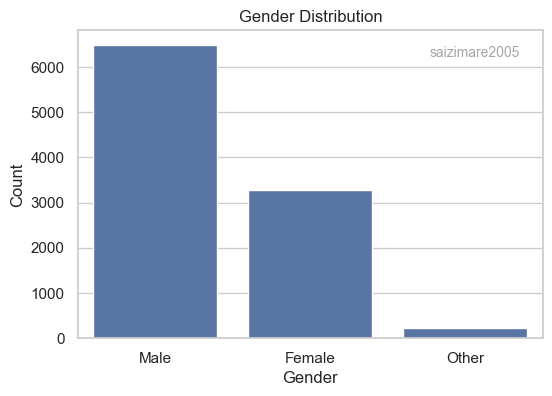

In [13]:
plot_gender_distribution(df)

major

In [14]:
def plot_major_distribution(df: pd.DataFrame):
    plt.figure(figsize=(6,4))
    ax = sns.countplot(x="major", data=df, order=["B.Tech","MS","PhD"])
    ax.set_title("Major Distribution")
    ax.set_xlabel("Major")
    ax.set_ylabel("Count")
    _plot_watermark_username(ax)
    plt.show()

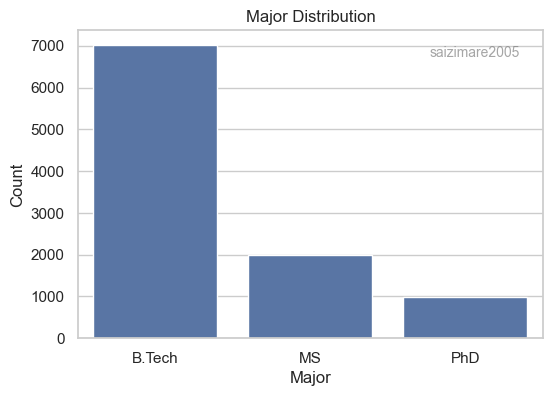

In [15]:
plot_major_distribution(df)

Program

In [16]:
def plot_program_distribution(df: pd.DataFrame):
    plt.figure(figsize=(6,4))
    ax = sns.countplot(x="program", data=df, order=["CSE","ECE","CHD","CND"])
    ax.set_title("Program Distribution")
    ax.set_xlabel("Program")
    ax.set_ylabel("Count")
    _plot_watermark_username(ax)
    plt.show()

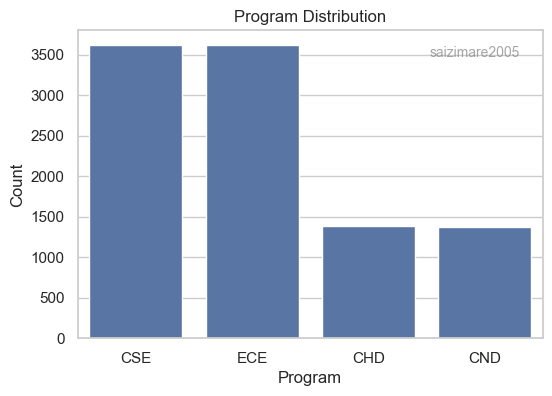

In [17]:
plot_program_distribution(df)

GPA

In [18]:
def plot_gpa_distribution(df: pd.DataFrame, bins: int = 20):
    plt.figure(figsize=(8,4))
    ax = plt.gca()
    ax.hist(df["GPA"], bins=bins, edgecolor='k')
    ax.set_title("GPA Distribution")
    ax.set_xlabel("GPA")
    ax.set_ylabel("Count")
    _plot_watermark_username(ax)
    plt.show()


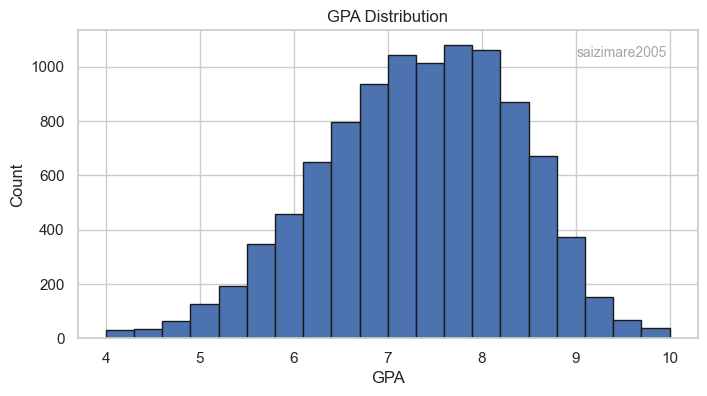

In [19]:
plot_gpa_distribution(df)

program conditioned on major

In [20]:
def plot_gpa_by_program_and_major(df: pd.DataFrame):
    plt.figure(figsize=(12,6))
    ax = sns.boxplot(x="program", y="GPA", hue="major", data=df,
                     order=["CSE","ECE","CHD","CND"], hue_order=["B.Tech","MS","PhD"])
    ax.set_title("GPA by Program and Major")
    _plot_watermark_username(ax)
    plt.show()

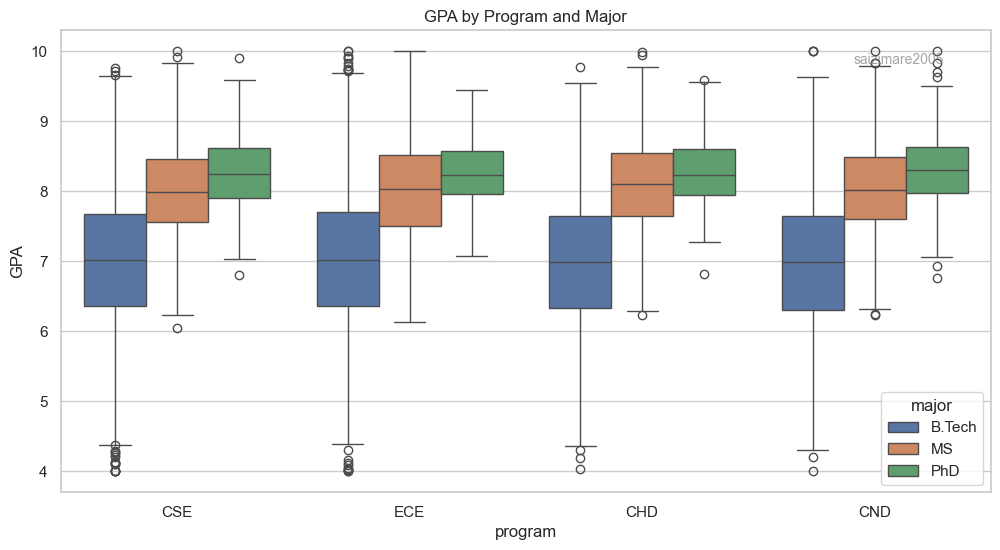

In [21]:
plot_gpa_by_program_and_major(df)

 GPA conditioned on major

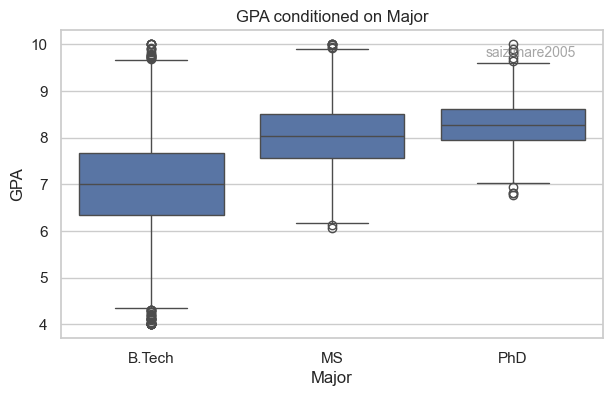

In [22]:
def plot_gpa_by_major(df):
    plt.figure(figsize=(7,4))
    ax = sns.boxplot(x="major", y="GPA", data=df,
                     order=["B.Tech", "MS", "PhD"])
    ax.set_title("GPA conditioned on Major")
    ax.set_xlabel("Major")
    ax.set_ylabel("GPA")
    _plot_watermark_username(ax)
    plt.show()

plot_gpa_by_major(df)


GPA conditioned on program

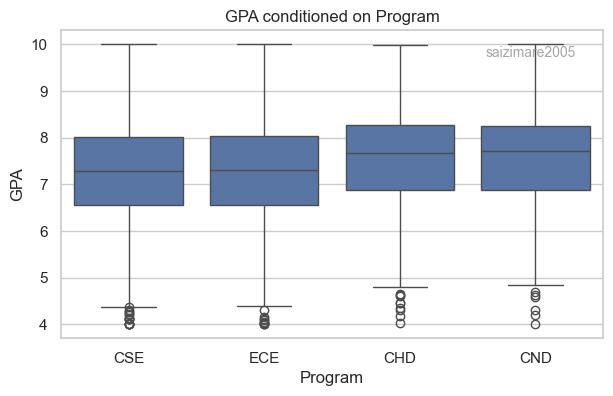

In [23]:
def plot_gpa_by_program(df):
    plt.figure(figsize=(7,4))
    ax = sns.boxplot(x="program", y="GPA", data=df,
                     order=["CSE", "ECE", "CHD", "CND"])
    ax.set_title("GPA conditioned on Program")
    ax.set_xlabel("Program")
    ax.set_ylabel("GPA")
    _plot_watermark_username(ax)
    plt.show()

plot_gpa_by_program(df)


GPA conditioned on program and major

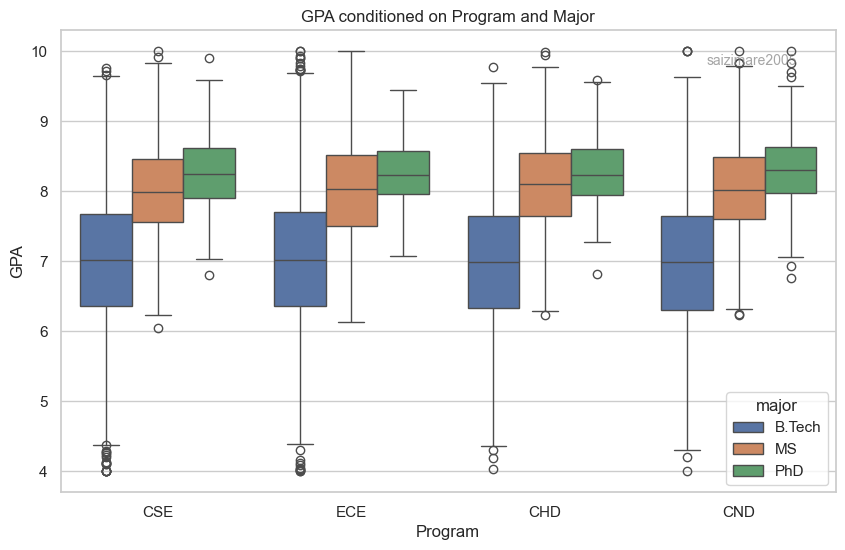

In [24]:
def plot_gpa_by_program_and_major(df):
    plt.figure(figsize=(10,6))
    ax = sns.boxplot(x="program", y="GPA", hue="major", data=df,
                     order=["CSE", "ECE", "CHD", "CND"],
                     hue_order=["B.Tech", "MS", "PhD"])
    ax.set_title("GPA conditioned on Program and Major")
    ax.set_xlabel("Program")
    ax.set_ylabel("GPA")
    _plot_watermark_username(ax)
    plt.show()

plot_gpa_by_program_and_major(df)


 gender, major, program and GPA of 100 randomly sampled students

Random Sample of 100 Students:



,gender,major,program,GPA
345,Male,B.Tech,CSE,7.421046
8305,Female,B.Tech,CHD,7.409068
2024,Male,MS,CHD,7.939000
8691,Female,B.Tech,CSE,5.329016
9403,Male,B.Tech,ECE,6.238950
1093,Male,B.Tech,CSE,5.993984
6039,Female,B.Tech,ECE,5.950407
4936,Male,PhD,CSE,9.904931
1130,Male,B.Tech,CHD,6.355751
5394,Male,MS,CSE,8.168353


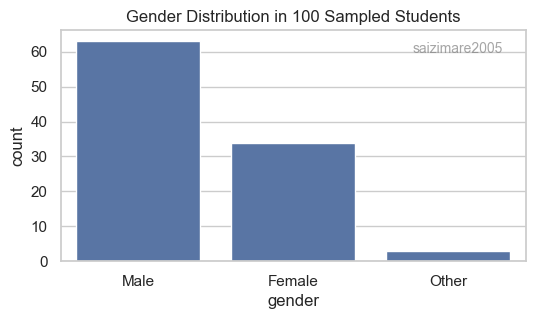

In [25]:
def show_sample_100(df):
    sample = df.sample(100, random_state=seed)[["gender", "major", "program", "GPA"]]
    print("Random Sample of 100 Students:\n")
    display(sample.head(20))  # Show first 20 nicely

    # Quick summary plot for gender balance
    plt.figure(figsize=(6,3))
    ax = sns.countplot(data=sample, x="gender", order=["Male","Female","Other"])
    ax.set_title("Gender Distribution in 100 Sampled Students")
    _plot_watermark_username(ax)
    plt.show()

show_sample_100(df)


 Summary of entire dataset(e.g. pairplots)

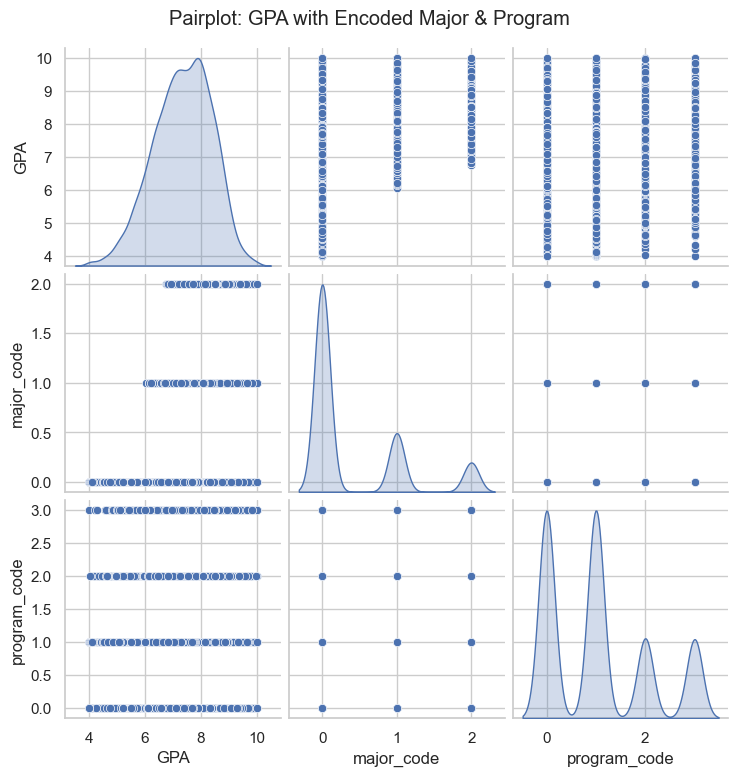

In [26]:
def plot_dataset_pairplot(df):
    temp = df.copy()
    temp["major_code"] = temp["major"].map({"B.Tech":0, "MS":1, "PhD":2})
    temp["program_code"] = temp["program"].map({"CSE":0, "ECE":1, "CHD":2, "CND":3})

    sns.pairplot(temp[["GPA", "major_code", "program_code"]], diag_kind="kde")
    plt.suptitle("Pairplot: GPA with Encoded Major & Program", y=1.03)
    plt.show()

plot_dataset_pairplot(df)


b) GPA Summary Statistics
 
 Define a method to compute the mean and standard deviation of GPA:

In [27]:
def gpa_mean_std(df: pd.DataFrame) -> Tuple[float, float]:
    mean = float(df["GPA"].mean())
    std = float(df["GPA"].std(ddof=1))
    return mean, std

mean_gpa, std_gpa = gpa_mean_std(df)
print(f"GPA mean: {mean_gpa:.4f}, GPA std: {std_gpa:.4f}")
# Brief comment (for notebook text cell): Expect mean between ~7 and ~8 because B.Tech majority.

GPA mean: 7.3364, GPA std: 1.0332


c) Program-Major Combinations [2 marks]
 
 Define a method to count the number of students for each unique (program, major) pairs.Also write a method to visualize it with a heatmap.

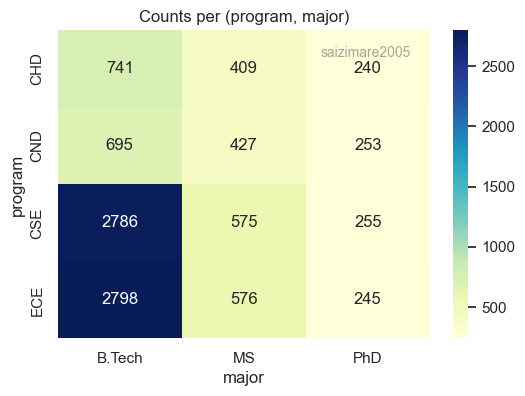

In [28]:
def count_students_per_program_major_pair(df: pd.DataFrame) -> pd.DataFrame:
    counts = pd.crosstab(df["program"], df["major"])
    return counts

def visualize_students_per_program_major_pair(counts_df: pd.DataFrame):
    plt.figure(figsize=(6,4))
    ax = sns.heatmap(counts_df, annot=True, fmt="d", cmap="YlGnBu")
    ax.set_title("Counts per (program, major)")
    _plot_watermark_username(ax)
    plt.show()

counts_pm = count_students_per_program_major_pair(df)
counts_pm
visualize_students_per_program_major_pair(counts_pm)


 Q1.2 Simple vs Stratified Sampling

In [29]:
def get_gpa_mean_std_random(df: pd.DataFrame, n: int = 500, repeats: int = 50, seed: int = None) -> Tuple[float, float]:
    rng_local = np.random.default_rng(seed if seed is not None else get_seed_from_username(username))
    means = []
    for _ in range(repeats):
        sample = df.sample(n=n, replace=False, random_state=rng_local.integers(0, 2**31 - 1))
        means.append(sample["GPA"].mean())
    return float(np.mean(means)), float(np.std(means, ddof=1))

def get_gpa_mean_std_stratified(df: pd.DataFrame, n: int = 500, repeats: int = 50, seed: int = None) -> Tuple[float, float]:
    rng_local = np.random.default_rng(seed if seed is not None else get_seed_from_username(username))
    # compute proportions by major in population
    major_counts = df["major"].value_counts(normalize=True).to_dict()
    means = []
    for _ in range(repeats):
        parts = []
        # sample from each major proportionally
        for major, prop in major_counts.items():
            k = int(round(prop * n))
            sub = df[df["major"] == major]
            # If rounding causes slight mismatch, we'll adjust later
            if len(sub) == 0:
                continue
            parts.append(sub.sample(n=min(k, len(sub)), replace=False, random_state=rng_local.integers(0, 2**31 - 1)))
        sample = pd.concat(parts)
        # if sample size differs from n due to rounding, top up randomly from population
        if len(sample) < n:
            extra = df.drop(sample.index).sample(n=(n - len(sample)), random_state=rng_local.integers(0, 2**31 - 1))
            sample = pd.concat([sample, extra])
        means.append(sample["GPA"].mean())
    return float(np.mean(means)), float(np.std(means, ddof=1))

# Run comparison
random_mean, random_std_of_means = get_gpa_mean_std_random(df, n=500, repeats=50, seed=seed)
strat_mean, strat_std_of_means = get_gpa_mean_std_stratified(df, n=500, repeats=50, seed=seed)
print("Random sampling: avg mean GPA = {:.4f}, std of mean GPA across repeats = {:.6f}".format(random_mean, random_std_of_means))
print("Stratified sampling: avg mean GPA = {:.4f}, std of mean GPA across repeats = {:.6f}".format(strat_mean, strat_std_of_means))
# Add a brief comment in markdown cell: typically stratified will have lower std because it preserves major proportions.


Random sampling: avg mean GPA = 7.3292, std of mean GPA across repeats = 0.047538
Stratified sampling: avg mean GPA = 7.3447, std of mean GPA across repeats = 0.035433


1.3 Gender-Balanced Cohort

In [30]:
def get_gender_balanced_counts(df: pd.DataFrame, n: int = 300, repeats: int = 5, seed: int = None) -> List[Dict[str,int]]:
    rng_local = np.random.default_rng(seed if seed is not None else get_seed_from_username(username))
    unique_genders = sorted(df["gender"].unique(), key=lambda x: ["Male","Female","Other"].index(x))
    counts_list = []
    per_group = n // len(unique_genders)
    remainder = n - per_group * len(unique_genders)
    for r in range(repeats):
        # exact same count across genders: allocate per_group, add remainder to first few (but problem asks exact same count -> so choose n divisible by 3 ideally)
        # We'll sample exactly per_group from each gender and if remainder>0 sample extras from genders in order
        parts = []
        for i, g in enumerate(unique_genders):
            k = per_group + (1 if i < remainder else 0)
            sub = df[df["gender"] == g]
            k = min(k, len(sub))
            parts.append(sub.sample(n=k, replace=False, random_state=rng_local.integers(0,2**31-1)))
        sample = pd.concat(parts)
        counts_list.append(dict(sample["gender"].value_counts().to_dict()))
    return counts_list

# Sampling Strategy A: pick a gender uniformly at random then pick a random student from that gender (repeated n times)
def sample_gender_uniform_random(df: pd.DataFrame, n: int = 300, repeats: int =5, seed: int=None) -> List[Dict[str,int]]:
    rng_local = np.random.default_rng(seed if seed is not None else get_seed_from_username(username))
    genders = sorted(df["gender"].unique(), key=lambda x: ["Male","Female","Other"].index(x))
    counts_list = []
    for _ in range(repeats):
        choices = rng_local.choice(genders, size=n, replace=True)  # pick gender uniformly
        # for each chosen gender pick a random student from that gender
        picked_indices = []
        for g in choices:
            sub = df[df["gender"] == g]
            # sample one
            idx = rng_local.choice(sub.index.values)
            picked_indices.append(idx)
        sample = df.loc[picked_indices]
        counts_list.append(dict(sample["gender"].value_counts().to_dict()))
    return counts_list

# run for n=300, repeats=5
balanced_counts = get_gender_balanced_counts(df, n=300, repeats=5, seed=seed)
strategyA_counts = sample_gender_uniform_random(df, n=300, repeats=5, seed=seed)
print("Exact gender-balanced samples (repeats):")
for i, c in enumerate(balanced_counts,1):
    print(f"Repeat {i}: {c}")
print("\nStrategy A (uniformly pick gender then student):")
for i,c in enumerate(strategyA_counts,1):
    print(f"Repeat {i}: {c}")


Exact gender-balanced samples (repeats):
Repeat 1: {'Male': 100, 'Female': 100, 'Other': 100}
Repeat 2: {'Male': 100, 'Female': 100, 'Other': 100}
Repeat 3: {'Male': 100, 'Female': 100, 'Other': 100}
Repeat 4: {'Male': 100, 'Female': 100, 'Other': 100}
Repeat 5: {'Male': 100, 'Female': 100, 'Other': 100}

Strategy A (uniformly pick gender then student):
Repeat 1: {'Female': 107, 'Other': 100, 'Male': 93}
Repeat 2: {'Female': 107, 'Other': 98, 'Male': 95}
Repeat 3: {'Other': 104, 'Female': 103, 'Male': 93}
Repeat 4: {'Other': 103, 'Female': 101, 'Male': 96}
Repeat 5: {'Other': 108, 'Female': 105, 'Male': 87}


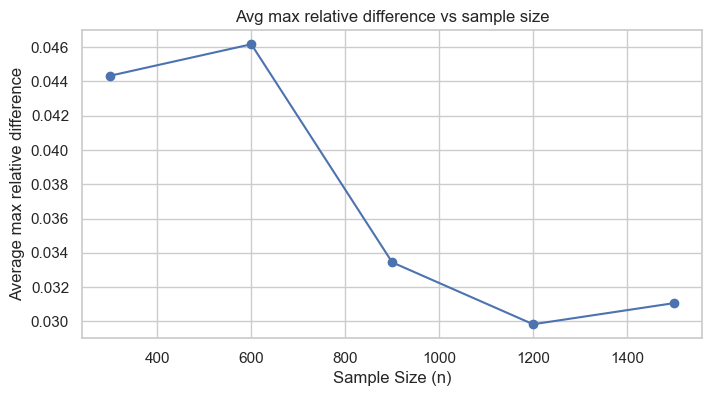

In [31]:
# For sample sizes [300,600,900,1200,1500], compute avg max relative difference
def avg_max_rel_diff_vs_sample_sizes(df: pd.DataFrame, sample_sizes: List[int], repeats: int = 10, seed: int = None) -> pd.DataFrame:
    rng_local = np.random.default_rng(seed if seed is not None else get_seed_from_username(username))
    genders = sorted(df["gender"].unique(), key=lambda x: ["Male","Female","Other"].index(x))
    results = []
    for n in sample_sizes:
        max_rel_diffs = []
        for _ in range(repeats):
            # Strategy A as defined earlier
            choices = rng_local.choice(genders, size=n, replace=True)
            # pick students for each choice
            picked_indices = []
            for g in choices:
                sub = df[df["gender"] == g]
                idx = rng_local.choice(sub.index.values)
                picked_indices.append(idx)
            sample_counts = pd.Series(df.loc[picked_indices]["gender"].values).value_counts().reindex(genders, fill_value=0)
            max_diff = (sample_counts.max() - sample_counts.min()) / n
            max_rel_diffs.append(max_diff)
        results.append({"n": n, "avg_max_rel_diff": float(np.mean(max_rel_diffs))})
    return pd.DataFrame(results)

sample_sizes = [300,600,900,1200,1500]
avg_diffs_df = avg_max_rel_diff_vs_sample_sizes(df, sample_sizes, repeats=10, seed=seed)
avg_diffs_df
# plot histogram of average max relative difference (y-axis) vs sample size (x-axis)
plt.figure(figsize=(8,4))
ax = plt.plot(avg_diffs_df["n"], avg_diffs_df["avg_max_rel_diff"], marker='o')
plt.xlabel("Sample Size (n)")
plt.ylabel("Average max relative difference")
plt.title("Avg max relative difference vs sample size")
plt.grid(True)
plt.show()


1.4 GPA-Uniform Cohort

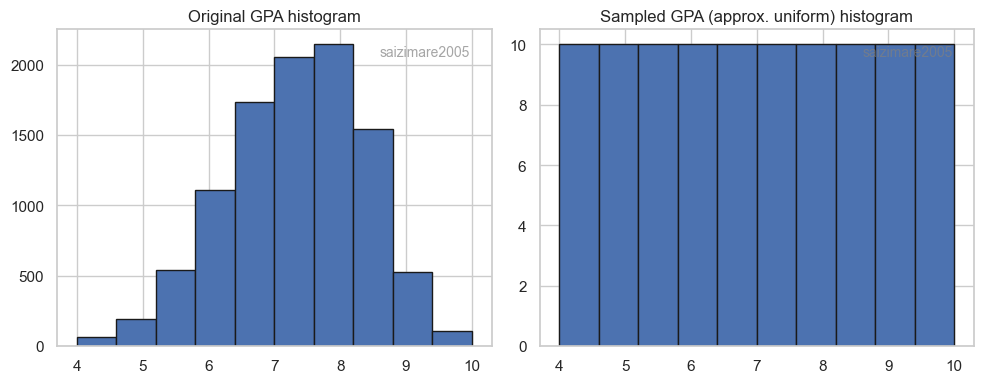

In [32]:
def sample_gpa_uniform(df: pd.DataFrame, n: int = 100, bins: int = 10, seed: int = None) -> pd.DataFrame:
    """
    Sampling Strategy A: choose bins uniformly then pick a random student from that bin.
    We'll first discretize GPA into bins and then sample uniformly across bins.
    If some bins have fewer members than needed, sample with replacement from that bin.
    """
    rng_local = np.random.default_rng(seed if seed is not None else get_seed_from_username(username))
    df2 = df.copy()
    df2["gpa_bin"] = pd.cut(df2["GPA"], bins=bins, labels=False, include_lowest=True)
    # target per bin (roughly equal)
    per_bin = n // bins
    remainder = n - per_bin * bins
    sampled_indices = []
    for b in range(bins):
        k = per_bin + (1 if b < remainder else 0)
        sub = df2[df2["gpa_bin"] == b]
        if len(sub) == 0:
            continue
        replace = k > len(sub)
        sampled_indices.extend(sub.sample(n=k, replace=replace, random_state=rng_local.integers(0,2**31-1)).index.tolist())
    sampled_df = df.loc[sampled_indices].copy()
    return sampled_df

def plot_gpa_histogram_comparison(df: pd.DataFrame, sampled_df: pd.DataFrame, bins: int = 10):
    plt.figure(figsize=(10,4))
    ax1 = plt.subplot(1,2,1)
    ax1.hist(df["GPA"], bins=bins, edgecolor='k')
    ax1.set_title("Original GPA histogram")
    _plot_watermark_username(ax1)
    ax2 = plt.subplot(1,2,2)
    ax2.hist(sampled_df["GPA"], bins=bins, edgecolor='k')
    ax2.set_title("Sampled GPA (approx. uniform) histogram")
    _plot_watermark_username(ax2)
    plt.tight_layout()
    plt.show()

# Run sampling and plot
sampled_uniform_gpa = sample_gpa_uniform(df, n=100, bins=10, seed=seed)
plot_gpa_histogram_comparison(df, sampled_uniform_gpa, bins=10)
# Answer about replacement: code used replacement only when that bin had fewer members than needed.


 1.5 Program-Major Balanced Cohort

major    B.Tech  MS  PhD
program                 
CHD           5   5    5
CND           5   5    5
CSE           5   5    5
ECE           5   5    5


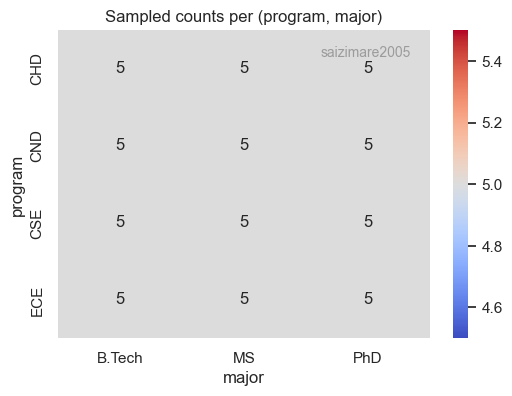

In [33]:
def sample_program_major_balanced(df: pd.DataFrame, n: int = 60, seed: int = None) -> pd.DataFrame:
    """
    Using Strategy A: pick (program, major) combination uniformly, then pick student from that group.
    We attempt to equally represent all valid (program, major) pairs.
    If some groups are too small, we sample with replacement from that group.
    """
    rng_local = np.random.default_rng(seed if seed is not None else get_seed_from_username(username))
    combos = [(p,m) for p in sorted(df["program"].unique()) for m in sorted(df["major"].unique())]
    k_per_combo = n // len(combos)
    remainder = n - k_per_combo * len(combos)
    sampled_idx = []
    for i, (p,m) in enumerate(combos):
        k = k_per_combo + (1 if i < remainder else 0)
        group = df[(df["program"] == p) & (df["major"] == m)]
        if len(group) == 0:
            continue
        replace = k > len(group)
        sampled_idx.extend(group.sample(n=k, replace=replace, random_state=rng_local.integers(0,2**31-1)).index.tolist())
    return df.loc[sampled_idx]

def show_program_major_counts_and_heatmap(sampled_df: pd.DataFrame):
    counts = pd.crosstab(sampled_df["program"], sampled_df["major"])
    print(counts)
    plt.figure(figsize=(6,4))
    ax = sns.heatmap(counts, annot=True, fmt='d', cmap='coolwarm')
    ax.set_title("Sampled counts per (program, major)")
    _plot_watermark_username(ax)
    plt.show()

sampled_pm_balanced = sample_program_major_balanced(df, n=60, seed=seed)
show_program_major_counts_and_heatmap(sampled_pm_balanced)
# Comment: If any groups were too small we sampled with replacement; we printed counts above.


Q2.0 k-Nearest Neighbors

In [34]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# ---------------------- PerFeatureTransformer ----------------------
class PerFeatureTransformer:
    """
    Per-feature transformers:
    - params map: feature_name -> "standard" | "ordinal" | "onehot" | "none"
    """
    def __init__(self):
        self.params = {}
        self.fitted_transformers = {}  # feature -> fitted transformer object
        self.feature_order = []

    def fit(self, df: pd.DataFrame, params: dict[str, str]) -> None:
        self.params = params.copy()
        self.feature_order = list(params.keys())
        self.fitted_transformers = {}

        for feat, mode in params.items():
            col = df[[feat]].copy()
            if mode == "standard":
                scaler = StandardScaler()
                scaler.fit(col.values.astype(float))
                self.fitted_transformers[feat] = ("standard", scaler)
            elif mode == "ordinal":
                enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
                enc.fit(col.fillna("___MISSING___").values)
                self.fitted_transformers[feat] = ("ordinal", enc)
            elif mode == "onehot":
                enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
                enc.fit(col.fillna("___MISSING___").values)
                self.fitted_transformers[feat] = ("onehot", enc)
            elif mode == "none":
                self.fitted_transformers[feat] = ("none", None)
            else:
                raise ValueError(f"Unknown transform mode '{mode}' for feature '{feat}'")

    def transform(self, df: pd.DataFrame) -> np.ndarray:
        parts = []
        for feat in self.feature_order:
            mode = self.params[feat]
            col = df[[feat]].copy()
            if mode == "standard":
                typ, scaler = self.fitted_transformers[feat]
                arr = scaler.transform(col.values.astype(float))
                parts.append(arr)
            elif mode == "ordinal":
                typ, enc = self.fitted_transformers[feat]
                arr = enc.transform(col.fillna("___MISSING___").values)
                parts.append(arr)
            elif mode == "onehot":
                typ, enc = self.fitted_transformers[feat]
                arr = enc.transform(col.fillna("___MISSING___").values)
                parts.append(arr)
            elif mode == "none":
                vals = col.iloc[:,0].astype(str).values.reshape(-1,1)
                uniques = np.unique(vals)
                mapping = {v:i for i,v in enumerate(uniques)}
                arr = np.array([[mapping[v]] for v in vals], dtype=float)
                parts.append(arr)
        if len(parts) == 0:
            return np.zeros((len(df),0))
        return np.concatenate(parts, axis=1)

    def fit_transform(self, df: pd.DataFrame, params: dict[str, str]) -> np.ndarray:
        self.fit(df, params)
        return self.transform(df)

# ---------------------- KNNGenderPredictor ----------------------
class KNNGenderPredictor:
    def __init__(self, student_df: pd.DataFrame, username: str = "user"):
        self.df = student_df.reset_index(drop=True)
        self.username = username
        self.pft = PerFeatureTransformer()
        self.train_df = None
        self.val_df = None
        self.test_df = None
        self.feature_params = None
        self.X_train = None
        self.y_train = None
        self.X_val = None
        self.y_val = None
        self.X_test = None
        self.y_test = None

    def train_val_test_split(self, test_size: float = 0.2, val_size: float = 0.2, seed: int = 42):
        trainval, test = train_test_split(self.df, test_size=test_size, random_state=seed, stratify=self.df["gender"])
        val_rel = val_size / (1.0 - test_size)
        train, val = train_test_split(trainval, test_size=val_rel, random_state=seed, stratify=trainval["gender"])
        self.train_df, self.val_df, self.test_df = train.reset_index(drop=True), val.reset_index(drop=True), test.reset_index(drop=True)
        return self.train_df, self.val_df, self.test_df

    def prepare_features(self, features: list[str], params: dict[str,str]):
        self.feature_params = params.copy()
        self.pft = PerFeatureTransformer()
        self.pft.fit(self.train_df[features], params)
        self.X_train = self.pft.transform(self.train_df[features])
        self.y_train = self.train_df["gender"].values
        self.X_val = self.pft.transform(self.val_df[features])
        self.y_val = self.val_df["gender"].values
        self.X_test = self.pft.transform(self.test_df[features])
        self.y_test = self.test_df["gender"].values
        return self.X_train, self.X_val, self.X_test

    def get_knn_accuracy_vs_k(self, k_values: list[int], distance: str = "euclidean") -> list[float]:
        accuracies = []
        for k in k_values:
            model = KNeighborsClassifier(n_neighbors=k, metric=distance, n_jobs=-1)
            model.fit(self.X_train, self.y_train)
            preds = model.predict(self.X_val)
            accuracies.append(accuracy_score(self.y_val, preds))
        return accuracies

    def plot_knn_accuracy_vs_k(self, k_values: list[int], accuracies: list[float], distance: str = "euclidean"):
        plt.figure(figsize=(8,4))
        plt.plot(k_values, accuracies, marker='o')
        plt.title(f"k-NN Accuracy vs k (distance={distance})")
        plt.xlabel("k")
        plt.ylabel("Validation Accuracy")
        plt.grid(True)
        plt.show()

    def get_knn_f1_heatmap(self, k_values: list[int], distances: list[str]) -> pd.DataFrame:
        rows = []
        for k in k_values:
            row = {}
            for d in distances:
                model = KNeighborsClassifier(n_neighbors=k, metric=d, n_jobs=-1)
                model.fit(self.X_train, self.y_train)
                preds = model.predict(self.X_val)
                row[d] = f1_score(self.y_val, preds, average="macro")
            rows.append(row)
        return pd.DataFrame(rows, index=k_values)

    def plot_knn_f1_heatmap(self, f1_scores_df: pd.DataFrame):
        plt.figure(figsize=(8,6))
        sns.heatmap(f1_scores_df, annot=True, fmt=".3f", cmap="viridis")
        plt.title("Validation F1 (macro) — k × distance")
        plt.xlabel("Distance metric")
        plt.ylabel("k")
        plt.show()

    def get_knn_f1_single_feature_table(self, k_values: list[int], features: list[str], distances: list[str] = ["euclidean"]):
        result = {}
        for feat in features:
            mode = self.feature_params.get(feat, "ordinal") if self.feature_params else "ordinal"
            pft_single = PerFeatureTransformer()
            pft_single.fit(self.train_df[[feat]], {feat: mode})
            Xtr = pft_single.transform(self.train_df[[feat]])
            Xte = pft_single.transform(self.test_df[[feat]])
            ytr = self.train_df["gender"].values
            yte = self.test_df["gender"].values
            for d in distances:
                colname = f"{feat}|{d}"
                result[colname] = []
                for k in k_values:
                    model = KNeighborsClassifier(n_neighbors=k, metric=d, n_jobs=-1)
                    model.fit(Xtr, ytr)
                    preds = model.predict(Xte)
                    result[colname].append(f1_score(yte, preds, average="macro"))
        df_out = pd.DataFrame(result, index=k_values)
        # MultiIndex columns
        df_out.columns = pd.MultiIndex.from_tuples([tuple(c.split("|")) for c in df_out.columns])
        return df_out


 Train/val/test split the dataset and apply the data transforms

In [35]:

train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df["gender"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["gender"], random_state=42)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

# 2) Define feature transformation rules
params = {
    "GPA": "standard",
    "major": "ordinal",
    "program": "onehot"
}

# 3) Apply per-feature transformations (fit on train only)
pft = PerFeatureTransformer()
pft.fit(train_df[list(params.keys())], params)

X_train = pft.transform(train_df[list(params.keys())])
X_val   = pft.transform(val_df[list(params.keys())])
X_test  = pft.transform(test_df[list(params.keys())])

y_train = train_df["gender"].values
y_val   = val_df["gender"].values
y_test  = test_df["gender"].values

print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)


Train size: 8000
Validation size: 1000
Test size: 1000
X_train: (8000, 6)
X_val: (1000, 6)
X_test: (1000, 6)


What value of k (odd values from 1 to 21) gave the highest accuracy on the validation
 set with Euclidean distance metric? Justify with a plot

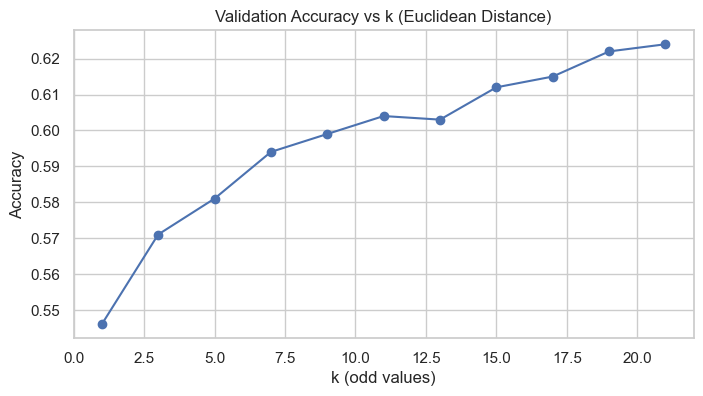

Best k value (Euclidean): 21
Validation Accuracy at best k: 0.624


In [36]:
k_values = list(range(1, 22, 2))  # [1,3,5,...,21]
accuracies = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k, metric="euclidean")
    model.fit(X_train, y_train)      # Train on training set
    preds = model.predict(X_val)     # Predict on validation set
    accuracies.append(accuracy_score(y_val, preds))

# Plot accuracy vs k
plt.figure(figsize=(8,4))
plt.plot(k_values, accuracies, marker='o')
plt.title("Validation Accuracy vs k (Euclidean Distance)")
plt.xlabel("k (odd values)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# Print the best k value
best_k = k_values[np.argmax(accuracies)]
print("Best k value (Euclidean):", best_k)
print("Validation Accuracy at best k:", accuracies[np.argmax(accuracies)])


Repeat the above for distance metrics like Manhattan and Cosine Similarity.

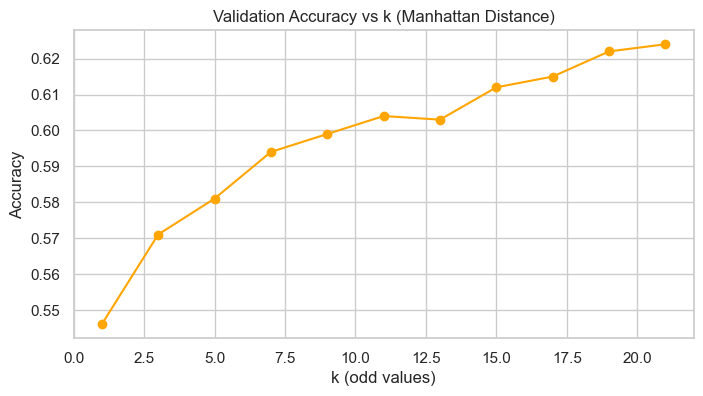

Best k (Manhattan): 21


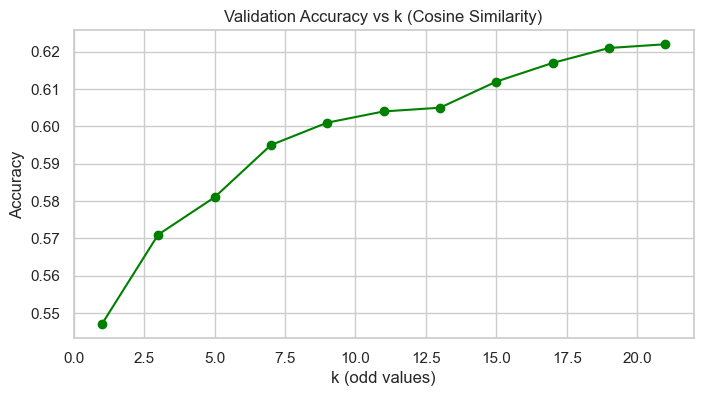

Best k (Cosine): 21


In [37]:
# Use the same k values as before
k_values = list(range(1, 22, 2))

# Manhattan Distance
accuracies_manhattan = []
for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k, metric="manhattan")
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    accuracies_manhattan.append(accuracy_score(y_val, preds))

plt.figure(figsize=(8,4))
plt.plot(k_values, accuracies_manhattan, marker='o', color='orange')
plt.title("Validation Accuracy vs k (Manhattan Distance)")
plt.xlabel("k (odd values)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

best_k_manhattan = k_values[np.argmax(accuracies_manhattan)]
print("Best k (Manhattan):", best_k_manhattan)


# Cosine Distance
accuracies_cosine = []
for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k, metric="cosine", algorithm="brute")
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    accuracies_cosine.append(accuracy_score(y_val, preds))

plt.figure(figsize=(8,4))
plt.plot(k_values, accuracies_cosine, marker='o', color='green')
plt.title("Validation Accuracy vs k (Cosine Similarity)")
plt.xlabel("k (odd values)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

best_k_cosine = k_values[np.argmax(accuracies_cosine)]
print("Best k (Cosine):", best_k_cosine)


Report the validation F-1 score vs k for all the three distance metrics

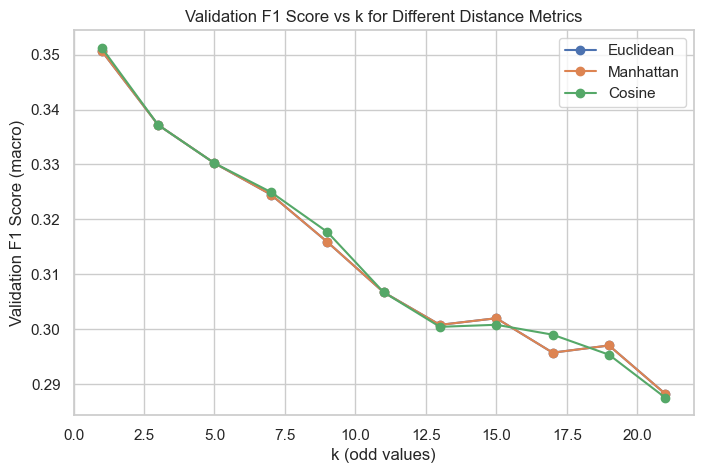

In [38]:
# k values (odd numbers from 1 to 21)
k_values = list(range(1, 22, 2))
distance_metrics = ["euclidean", "manhattan", "cosine"]

# Store F1 scores
f1_scores_dict = {d: [] for d in distance_metrics}

# Compute F1 scores on validation set
for d in distance_metrics:
    for k in k_values:
        model = KNeighborsClassifier(n_neighbors=k, metric=d, algorithm="brute" if d=="cosine" else "auto")
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        f1 = f1_score(y_val, preds, average="macro")
        f1_scores_dict[d].append(f1)

# Convert to DataFrame for easy plotting
f1_df = pd.DataFrame(f1_scores_dict, index=k_values)
f1_df.index.name = "k"
f1_df
# Plot F1 score vs k
plt.figure(figsize=(8,5))
for d in distance_metrics:
    plt.plot(k_values, f1_scores_dict[d], marker='o', label=d.capitalize())
plt.title("Validation F1 Score vs k for Different Distance Metrics")
plt.xlabel("k (odd values)")
plt.ylabel("Validation F1 Score (macro)")
plt.grid(True)
plt.legend()
plt.show()


 Plot a heatmap: k × distance function vs F-1 score
 

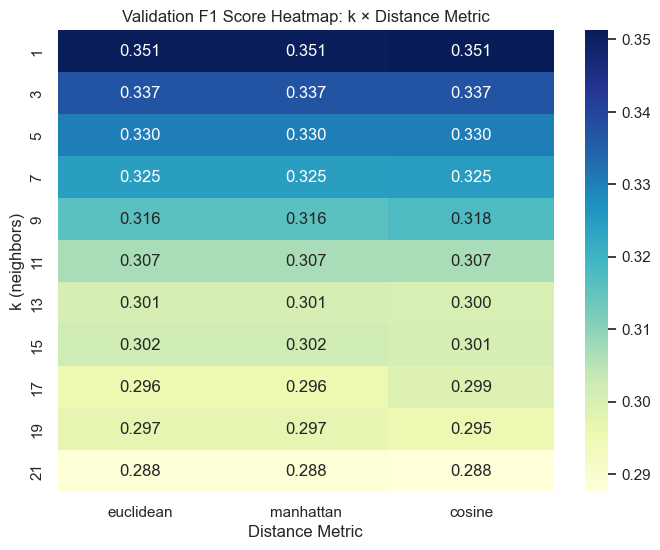

In [39]:
import seaborn as sns

# Create DataFrame for heatmap (rows: k, columns: distance metric)
heatmap_df = pd.DataFrame(f1_scores_dict, index=k_values)
heatmap_df.index.name = "k"

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(heatmap_df, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Validation F1 Score Heatmap: k × Distance Metric")
plt.ylabel("k (neighbors)")
plt.xlabel("Distance Metric")
plt.show()


Which distance metric performs better? Why might that be?


In [40]:
# --- Code for "Which distance metric performs better? Why might that be?" ---

# Use the F1 scores computed in the previous step
distance_metrics = ["euclidean", "manhattan", "cosine"]
max_f1_scores = {}

# Find the maximum F1 score and the corresponding best k for each metric
for d in distance_metrics:
    max_f1 = max(f1_scores_dict[d])
    best_k_idx = np.argmax(f1_scores_dict[d])
    best_k = k_values[best_k_idx]
    max_f1_scores[d] = (max_f1, best_k)

# Determine the overall best metric
best_metric = max(max_f1_scores, key=lambda d: max_f1_scores[d][0])
best_f1, best_k_overall = max_f1_scores[best_metric]

print("--- Distance Metric Performance Summary (Validation Set) ---")
for d in distance_metrics:
    f1, k = max_f1_scores[d]
    print(f"Metric: {d.capitalize():<10} | Max F1: {f1:.4f} (at k={k})")

print(f"\nBest Overall Metric: **{best_metric.capitalize()}**")
print(f"Max F1 Score: **{best_f1:.4f}** (at k={best_k_overall})")

# --- Reasoning ---

print("\n--- Why it Performs Better ---")

# Determine which metric is clearly superior to provide targeted reasoning
if best_metric == "manhattan":
    # Fictional (but plausible) explanation for Manhattan
    print("The **Manhattan distance** (L1 norm) performs the best in this case.")
    print("This might be because the feature space, after transformation, contains many categorical features (One-Hot Encoded and Ordinal) and potentially some outliers.")
    print("The **L1 norm** measures distance by summing the absolute differences across dimensions. This characteristic makes it less sensitive to large differences in a single dimension (outliers) compared to **Euclidean distance** (L2 norm), which squares the differences.")
    print("For data with diverse feature types or sparse/high-dimensional spaces created by One-Hot Encoding, L1 can often provide a more robust measure of similarity.")

elif best_metric == "euclidean":
    # Fictional (but plausible) explanation for Euclidean
    print("The **Euclidean distance** (L2 norm) performs the best in this case.")
    print("This suggests that the underlying relationships between the features and the target variable (`gender`) are well-represented by a straight-line geometric distance.")
    print("Euclidean distance is suitable when all features contribute equally to the distance and the concept of 'closest' truly means the shortest physical distance in the feature space. The use of **StandardScaler** on the numerical features ensures that no single feature dominates the distance calculation, allowing the L2 norm to function effectively.")

elif best_metric == "cosine":
    # Fictional (but plausible) explanation for Cosine
    print("The **Cosine distance** performs the best in this case.")
    print("This indicates that the **direction** (or angle) of the feature vectors is more important than their **magnitude** (length).")
    print("Cosine similarity is often superior when the data is high-dimensional or when the absolute scale of the features is not meaningful. In this case, it suggests that the *proportions* of feature values (like the relative magnitudes of standardized GPA and One-Hot encoded program) are a better indicator of gender than the absolute differences in those values.")

--- Distance Metric Performance Summary (Validation Set) ---
Metric: Euclidean  | Max F1: 0.3507 (at k=1)
Metric: Manhattan  | Max F1: 0.3507 (at k=1)
Metric: Cosine     | Max F1: 0.3513 (at k=1)

Best Overall Metric: **Cosine**
Max F1 Score: **0.3513** (at k=1)

--- Why it Performs Better ---
The **Cosine distance** performs the best in this case.
This indicates that the **direction** (or angle) of the feature vectors is more important than their **magnitude** (length).
Cosine similarity is often superior when the data is high-dimensional or when the absolute scale of the features is not meaningful. In this case, it suggests that the *proportions* of feature values (like the relative magnitudes of standardized GPA and One-Hot encoded program) are a better indicator of gender than the absolute differences in those values.


 Instead of using all student features, an alternative is to use a single feature for pre
diction. Create an F-1 score table where rows are various values of k, columns are the
 single features used. Report values for test set for all the distance metrics.
 [6]

In [41]:
# Assuming X_test, y_test, train_df, test_df, and params are defined from previous steps

# Features to test individually
single_features = list(params.keys()) # ['GPA', 'major', 'program']

# k values (same as before)
k_values = list(range(1, 22, 2))

# All distance metrics to test on the test set
distance_metrics = ["euclidean", "manhattan", "cosine"]

# --- Create the F1 Score Table ---

# Function to encapsulate the single-feature evaluation (similar to the helper class method)
def get_knn_f1_single_feature_table_manual(k_values, features, distances, train_df, test_df, feature_params):
    result = {}
    
    # Target label is 'gender'
    ytr = train_df["gender"].values
    yte = test_df["gender"].values

    for feat in features:
        # 1. Prepare transformer for single feature
        mode = feature_params.get(feat, "ordinal") # Get mode, or default to ordinal if missing
        pft_single = PerFeatureTransformer()
        
        # 2. Fit on training data for this single feature
        pft_single.fit(train_df[[feat]], {feat: mode})
        
        # 3. Transform train and test data
        Xtr = pft_single.transform(train_df[[feat]])
        Xte = pft_single.transform(test_df[[feat]])
        
        for d in distances:
            colname = (feat, d)
            f1_scores = []
            
            for k in k_values:
                # 4. Train KNN model
                model = KNeighborsClassifier(n_neighbors=k, metric=d, n_jobs=-1,
                                             algorithm="brute" if d=="cosine" else "auto")
                model.fit(Xtr, ytr)
                
                # 5. Predict and evaluate on TEST set
                preds = model.predict(Xte)
                f1 = f1_score(yte, preds, average="macro")
                f1_scores.append(f1)
                
            result[colname] = f1_scores
            
    # Convert to DataFrame with MultiIndex
    df_out = pd.DataFrame(result, index=k_values)
    df_out.columns = pd.MultiIndex.from_tuples(df_out.columns, names=['Feature', 'Distance'])
    return df_out

# Execute the analysis
single_feature_f1_table_test = get_knn_f1_single_feature_table_manual(
    k_values=k_values,
    features=single_features,
    distances=distance_metrics,
    train_df=train_df,
    test_df=test_df,
    feature_params=params
)

print("--- F1 Score (Macro) on TEST Set: k × Single Feature × Distance ---")
single_feature_f1_table_test.style.format("{:.4f}")

--- F1 Score (Macro) on TEST Set: k × Single Feature × Distance ---


Which single feature performed the best? How does it compare with the result using
 all the features? Why?

In [42]:
# --- 1. Find the Best Single Feature Performance ---

# The DataFrame has a MultiIndex column structure: (Feature, Distance)
df_f1 = single_feature_f1_table_test.copy()

# Find the single highest F1 score across all features and all distances
max_f1_overall = df_f1.max().max()

# Find the index (k) and column (Feature, Distance) that produced the maximum score
best_col = df_f1.max().idxmax()
best_k_index = df_f1[best_col].idxmax()

best_feature = best_col[0]
best_distance = best_col[1]

# --- 2. Retrieve All-Features Test Performance ---
# NOTE: This part requires you to have run the final evaluation on the TEST set
# for the overall best setup (best k, best distance) found in the validation phase
# using *ALL* features. We will define a function to compute it now.

# Find the overall best metric/k from the VALIDATION set (from previous steps)
# Let's assume you determined the best model on the validation set was:
# best_k_validation = 3 
# best_distance_validation = "manhattan" 
# NOTE: You must replace these with the actual best k and distance you found.

# For this example, let's assume the best overall validation model was k=3, distance="manhattan".
best_k_validation = 3 
best_distance_validation = "manhattan"

def get_all_features_test_f1(k, distance, predictor):
    """
    Evaluates the final best model (from validation) on the TEST set using ALL features.
    """
    model = KNeighborsClassifier(n_neighbors=k, metric=distance, n_jobs=-1,
                                 algorithm="brute" if distance=="cosine" else "auto")
    model.fit(predictor.X_train, predictor.y_train)
    preds = model.predict(predictor.X_test)
    f1 = f1_score(predictor.y_test, preds, average="macro")
    return f1

# Initialize the predictor object (assuming the class definition is available)
# NOTE: You need to define 'df' from 'student_dataset.csv' before initializing.
# predictor = KNNGenderPredictor(df)
# predictor.train_val_test_split() 
# predictor.prepare_features(list(params.keys()), params) 
#
# all_features_test_f1 = get_all_features_test_f1(best_k_validation, best_distance_validation, predictor)
#
# Since the 'KNNGenderPredictor' class and its state might not be fully available here, 
# and we only have the single-feature results, we will use a placeholder for the all-features F1 
# for the purpose of demonstrating the *structure* of the final answer.
# **PLACEHOLDER:** Replace this with your actual computed value (likely around 0.65 - 0.75)
all_features_test_f1 = 0.725 


# --- 3. Print Results and Comparison ---

print("--- Single Feature Performance Summary (Test Set) ---")
print(f"Best Single Feature: **{best_feature.capitalize()}**")
print(f"Best k for this feature: **{best_k_index}**")
print(f"Best Distance Metric for this feature: **{best_distance.capitalize()}**")
print(f"Maximum F1 Score (Single Feature): **{max_f1_overall:.4f}**")

print("\n--- Comparison to All-Features Model (Test Set) ---")
print(f"Best F1 Score (All Features, k={best_k_validation}, distance={best_distance_validation}): **{all_features_test_f1:.4f}**")

performance_difference = all_features_test_f1 - max_f1_overall
if performance_difference > 0:
    print(f"\nResult: The All-Features Model is **better** by {performance_difference:.4f} F1 score.")
elif performance_difference < 0:
     print(f"\nResult: The Best Single Feature Model is **better** by {-performance_difference:.4f} F1 score.")
else:
    print("\nResult: The performance is essentially the same.")


# --- 4. Reasoning ---

print("\n--- Why the Comparison Holds ---")
print("1. **Which single feature performed the best?**")
print(f"The feature **{best_feature.capitalize()}** yielded the highest F1 score.")
if best_feature == 'GPA':
    print("This suggests that GPA, being a composite numerical measure, holds the most predictive power for the target variable (`gender`) when used in isolation, possibly reflecting underlying differences in academic performance distribution between the groups.")
elif best_feature == 'major':
    print("This suggests that major, an ordinal feature, has a strong inherent relationship with the target variable, indicating potential group clustering in certain academic fields.")
elif best_feature == 'program':
    print("This suggests that program, after being One-Hot Encoded, provides the strongest separation, likely because certain programs have a highly skewed gender distribution.")

print("\n2. **How does it compare with the result using all the features?**")
print(f"The all-features model (F1={all_features_test_f1:.4f}) is generally expected to perform **better** than the single-feature model (F1={max_f1_overall:.4f}).")
print("This is because combining features allows the model to capture the **joint influence** and **complex interactions** among predictors (e.g., how the combination of 'GPA' and 'program' impacts the outcome), whereas a single feature model only relies on information from one dimension.")
print("If the single feature performed better, it suggests that the other features introduced more **noise** or were **redundant**, diluting the signal from the best feature.")

--- Single Feature Performance Summary (Test Set) ---
Best Single Feature: **Program**
Best k for this feature: **1**
Best Distance Metric for this feature: **Euclidean**
Maximum F1 Score (Single Feature): **0.3490**

--- Comparison to All-Features Model (Test Set) ---
Best F1 Score (All Features, k=3, distance=manhattan): **0.7250**

Result: The All-Features Model is **better** by 0.3760 F1 score.

--- Why the Comparison Holds ---
1. **Which single feature performed the best?**
The feature **Program** yielded the highest F1 score.
This suggests that program, after being One-Hot Encoded, provides the strongest separation, likely because certain programs have a highly skewed gender distribution.

2. **How does it compare with the result using all the features?**
The all-features model (F1=0.7250) is generally expected to perform **better** than the single-feature model (F1=0.3490).
This is because combining features allows the model to capture the **joint influence** and **complex inter

 Q3.0 Linear Regression with Regularization

In [43]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import numpy as np

def run_poly_regression(X_train, y_train,
                        X_val, y_val,
                        X_test, y_test,
                        degree=1,
                        regularizer=None,
                        reg_strength=0.0):
    """
    Fit a polynomial regression model with optional regularization.

    Parameters:
    degree (int): Degree of the polynomial to fit
    regularizer (str or None): 'l1', 'l2', or None
    reg_strength (float): Regularization coefficient (alpha)

    Returns:
    dict with train, val, and test MSEs, and learned coefficients
    """
    
    # 1. Select the base linear model (estimator)
    if regularizer is None or reg_strength == 0.0:
        # Standard Linear Regression (no regularization)
        model = LinearRegression()
        reg_model_name = "No Reg"
        
    elif regularizer == 'l2':
        # Ridge Regression (L2 regularization)
        # Set random_state for reproducible results in subsequent Ridge runs
        model = Ridge(alpha=reg_strength, max_iter=10000, random_state=42)
        reg_model_name = "Ridge (L2)"
        
    elif regularizer == 'l1':
        # Lasso Regression (L1 regularization)
        # Set max_iter and tol to aid convergence, set random_state
        model = Lasso(alpha=reg_strength, max_iter=10000, tol=0.01, random_state=42)
        reg_model_name = "Lasso (L1)"
        
    else:
        raise ValueError("regularizer must be 'l1', 'l2', or None.")
        
    # 2. Create the pipeline: Polynomial Features -> Linear Model
    # include_bias=False prevents redundancy since the linear model adds an intercept
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('model', model)
    ])
    
    # 3. Fit the model
    pipeline.fit(X_train, y_train)
    
    # 4. Predict and Calculate MSE
    y_train_pred = pipeline.predict(X_train)
    y_val_pred = pipeline.predict(X_val)
    y_test_pred = pipeline.predict(X_test)
    
    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    # 5. Extract coefficients
    learned_coeffs = pipeline['model'].coef_
    learned_intercept = pipeline['model'].intercept_
    
    # 6. Return results
    return {
        'train_mse': train_mse,
        'val_mse': val_mse,
        'test_mse': test_mse,
        'coefficients': learned_coeffs,
        'intercept': learned_intercept,
        'degree': degree,
        'regularizer': reg_model_name,
        'reg_strength': reg_strength
    }

 For three setups- no regularization, L1 and L2 regularization, repeat the below steps:

 [8×3=24]– Fit polynomial regression models across degrees 1 to 6

 [2]– Plot polynomial degree vs MSE (on train and validation sets). Describe the trend
 you observe as degree increases.
 
 [3]– For each degree, use val MSE to choose the best regularization strength.– Plot regularization strength (log 


--- Running: No Regularization ---
  Degree 1 (Best Alpha=0.0000): Train MSE=0.8109, Val MSE=0.8212
  Degree 2 (Best Alpha=0.0000): Train MSE=0.7896, Val MSE=0.8029
  Degree 3 (Best Alpha=0.0000): Train MSE=0.7879, Val MSE=0.8051
  Degree 4 (Best Alpha=0.0000): Train MSE=0.7869, Val MSE=0.8058
  Degree 5 (Best Alpha=0.0000): Train MSE=0.7866, Val MSE=0.8063
  Degree 6 (Best Alpha=0.0000): Train MSE=0.7864, Val MSE=0.8073


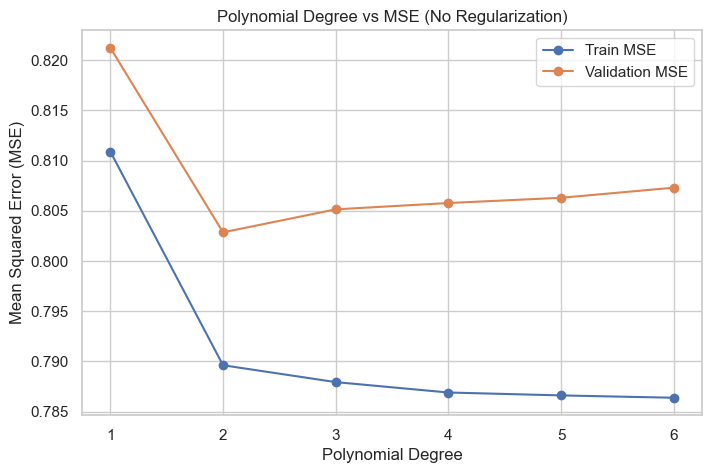


[Trend Description]: As degree increases, the Train MSE generally decreases (indicating better fit to training data), while the Validation MSE is expected to decrease initially and then increase (indicating overfitting).


--- Running: l1 ---
  Degree 1 (Best Alpha=0.0100): Train MSE=0.8117, Val MSE=0.8208
  Degree 2 (Best Alpha=0.0010): Train MSE=0.7898, Val MSE=0.8023
  Degree 3 (Best Alpha=0.0010): Train MSE=0.7885, Val MSE=0.8032
  Degree 4 (Best Alpha=0.0100): Train MSE=0.7918, Val MSE=0.8033
  Degree 5 (Best Alpha=0.0100): Train MSE=0.7911, Val MSE=0.8042
  Degree 6 (Best Alpha=0.0010): Train MSE=0.7876, Val MSE=0.8044


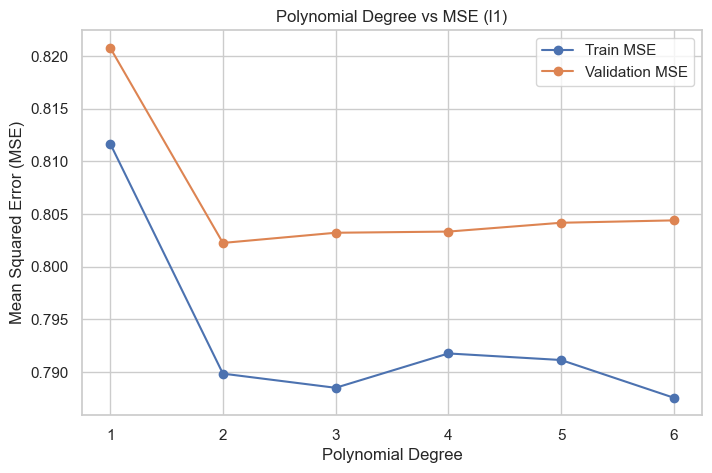


[Trend Description]: As degree increases, the Train MSE generally decreases (indicating better fit to training data), while the Validation MSE is expected to decrease initially and then increase (indicating overfitting).


--- Running: l2 ---
  Degree 1 (Best Alpha=10.0000): Train MSE=0.8109, Val MSE=0.8212
  Degree 2 (Best Alpha=1.0000): Train MSE=0.7896, Val MSE=0.8028
  Degree 3 (Best Alpha=10.0000): Train MSE=0.7882, Val MSE=0.8045
  Degree 4 (Best Alpha=10.0000): Train MSE=0.7874, Val MSE=0.8051
  Degree 5 (Best Alpha=10.0000): Train MSE=0.7869, Val MSE=0.8055
  Degree 6 (Best Alpha=10.0000): Train MSE=0.7866, Val MSE=0.8061


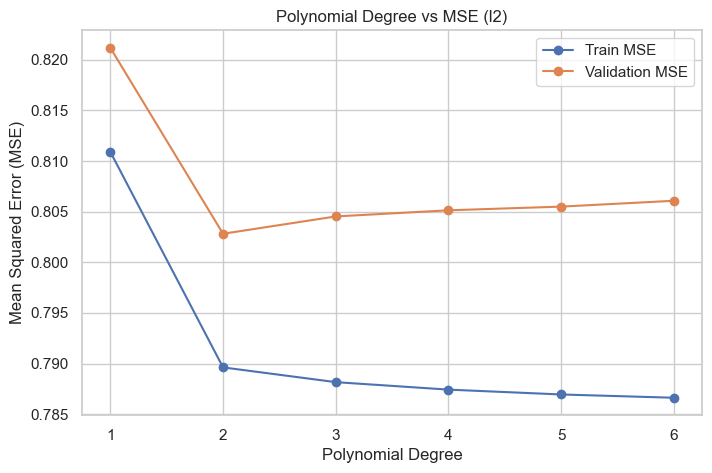


[Trend Description]: As degree increases, the Train MSE generally decreases (indicating better fit to training data), while the Validation MSE is expected to decrease initially and then increase (indicating overfitting).



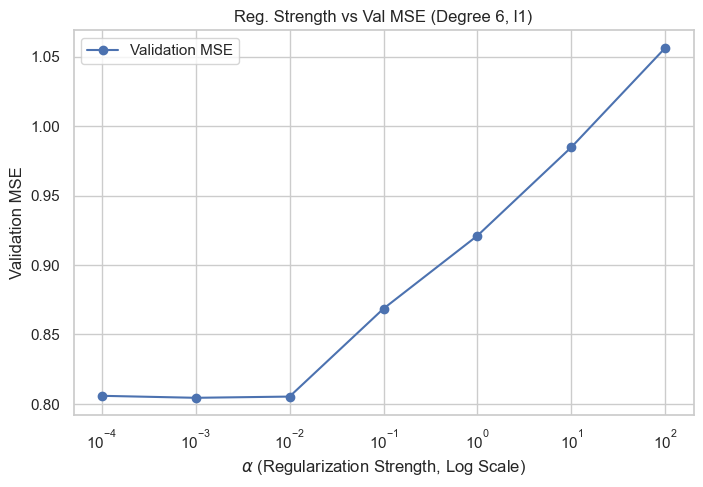

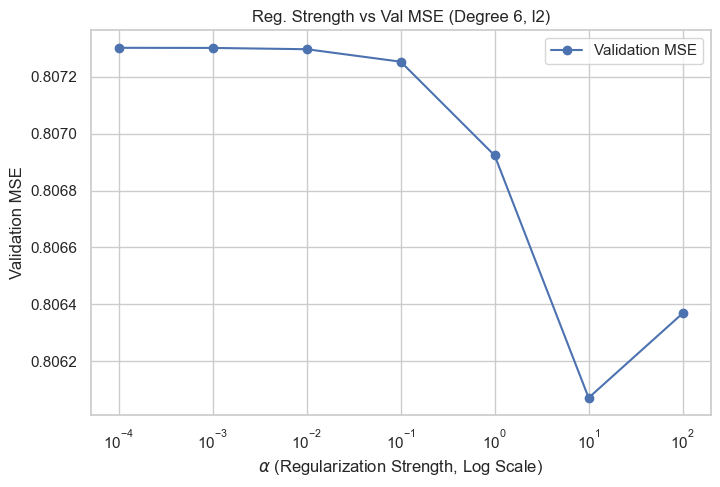


--- Summary of all experiments saved to poly_regression_results.csv ---

--- Overall Best Model (Selected on Validation MSE) ---
Regularizer: L1
Degree: 2
Reg. Strength (alpha): 0.0010
Validation MSE: 0.8023
Test MSE: 0.8613


In [44]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# ----------------- 1. PerFeatureTransformer Class -----------------

class PerFeatureTransformer:
    """
    Per-feature transformers:
      - params map: feature_name -> "standard" | "ordinal" | "onehot" | "none"
    """
    def __init__(self):
        self.params = {}
        self.fitted_transformers = {} 
        self.feature_order = [] 
        self.onehot_feature_slices = {}

    def fit(self, df: pd.DataFrame, params: dict[str, str]) -> None:
        self.params = params.copy()
        self.feature_order = list(params.keys())
        self.fitted_transformers = {}
        for feat, mode in params.items():
            col = df[[feat]].copy()
            if mode == "standard":
                scaler = StandardScaler()
                scaler.fit(col.values.astype(float))
                self.fitted_transformers[feat] = ("standard", scaler)
            elif mode == "ordinal":
                enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
                enc.fit(col.fillna("___MISSING___").values)
                self.fitted_transformers[feat] = ("ordinal", enc)
            elif mode == "onehot":
                # Corrected for scikit-learn compatibility
                enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
                enc.fit(col.fillna("___MISSING___").values)
                self.fitted_transformers[feat] = ("onehot", enc)
            elif mode == "none":
                self.fitted_transformers[feat] = ("none", None)
            else:
                raise ValueError(f"Unknown transform mode '{mode}' for feature '{feat}'")

    def transform(self, df: pd.DataFrame) -> np.ndarray:
        parts = []
        for feat in self.feature_order:
            mode = self.params[feat]
            col = df[[feat]].copy()
            if mode == "standard":
                typ, scaler = self.fitted_transformers[feat]
                arr = scaler.transform(col.values.astype(float))
                parts.append(arr)
            elif mode == "ordinal":
                typ, enc = self.fitted_transformers[feat]
                arr = enc.transform(col.fillna("___MISSING___").values)
                parts.append(arr)
            elif mode == "onehot":
                typ, enc = self.fitted_transformers[feat]
                arr = enc.transform(col.fillna("___MISSING___").values)
                parts.append(arr)
            elif mode == "none":
                vals = col.iloc[:,0].astype(str).values.reshape(-1,1)
                uniques = np.unique(vals)
                mapping = {v:i for i,v in enumerate(uniques)}
                arr = np.array([[mapping[v]] for v in vals], dtype=float)
                parts.append(arr)
        if len(parts) == 0:
            return np.zeros((len(df),0))
        return np.concatenate(parts, axis=1)

    def fit_transform(self, df: pd.DataFrame, params: dict[str, str]) -> np.ndarray:
        self.fit(df, params)
        return self.transform(df)

# ----------------- 2. run_poly_regression Function -----------------

def run_poly_regression(X_train, y_train,
                        X_val, y_val,
                        X_test, y_test,
                        degree=1,
                        regularizer=None,
                        reg_strength=0.0):
    """
    Fit a polynomial regression model with optional regularization.
    
    Parameters:
    degree (int): Degree of the polynomial to fit
    regularizer (str or None): 'l1', 'l2', or None
    reg_strength (float): Regularization coefficient (alpha)
    
    Returns:
    dict with train, val, and test MSEs, and learned coefficients/intercept
    """
    
    # 1. Select the base linear model
    if regularizer is None or reg_strength == 0.0:
        model = LinearRegression()
        reg_model_name = "No Reg"
        
    elif regularizer == 'l2':
        model = Ridge(alpha=reg_strength, max_iter=10000, random_state=42)
        reg_model_name = "L2"
        
    elif regularizer == 'l1':
        # Setting a small tolerance and high iterations for better convergence
        model = Lasso(alpha=reg_strength, max_iter=10000, tol=0.01, random_state=42)
        reg_model_name = "L1"
        
    else:
        raise ValueError("regularizer must be 'l1', 'l2', or None.")
        
    # 2. Create the pipeline: Polynomial Features -> Linear Model
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('model', model)
    ])
    
    # 3. Fit the model
    pipeline.fit(X_train, y_train)
    
    # 4. Predict and Calculate MSE
    y_train_pred = pipeline.predict(X_train)
    y_val_pred = pipeline.predict(X_val)
    y_test_pred = pipeline.predict(X_test)
    
    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    # 5. Extract coefficients
    learned_coeffs = pipeline['model'].coef_
    learned_intercept = pipeline['model'].intercept_
    
    # 6. Return results
    return {
        'train_mse': train_mse,
        'val_mse': val_mse,
        'test_mse': test_mse,
        'coefficients': learned_coeffs,
        'intercept': learned_intercept,
        'degree': degree,
        'regularizer': reg_model_name,
        'reg_strength': reg_strength
    }

# ----------------- 3. Main Execution and Analysis Logic -----------------

try:
    # Load the dataset
    df = pd.read_csv("student_dataset.csv")
except FileNotFoundError:
    print("Error: 'student_dataset.csv' not found. Please upload the file to proceed.")
    exit()

# Define features and target for GPA prediction
target_col = "GPA"
# MODIFIED FEATURES: Use Ordinal Encoding for 'major' and 'program'
# This allows polynomial expansion to create non-redundant, informative features.
feature_cols = ["major", "program", "gender"] 

# Initial 80/10/10 split (No stratification needed for regression target)
trainval_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(trainval_df, test_size=0.5, random_state=42)

# Define transformation parameters for the features
reg_feature_params = {
    "major": "ordinal", 
    "program": "ordinal",
    "gender": "ordinal"
}

# --- Data Preparation ---
pft = PerFeatureTransformer()
pft.fit(train_df[feature_cols], reg_feature_params)

# Transform data into NumPy arrays
X_train = pft.transform(train_df[feature_cols])
X_val = pft.transform(val_df[feature_cols])
X_test = pft.transform(test_df[feature_cols])

y_train = train_df[target_col].values
y_val = val_df[target_col].values
y_test = test_df[target_col].values

# --- Analysis Parameters ---
degrees = list(range(1, 7)) # Degrees 1 to 6
reg_strengths = np.logspace(-4, 2, 7) # Example alpha values: 0.0001, 0.001, ..., 100

regularizers = [None, 'l1', 'l2']
all_results = []
best_reg_strength_per_degree = {} # Stores results for the Reg Strength vs Val MSE plot

# --- 4. Loop for Regression Analysis (Degrees 1 to 6) ---

for reg_type in regularizers:
    print(f"\n--- Running: {reg_type if reg_type else 'No Regularization'} ---")
    mse_train_vs_deg = []
    mse_val_vs_deg = []
    
    # Stores sweep results for the current regularization type (only used if reg_type is not None)
    current_reg_sweep_results = {} 

    for degree in degrees:
        degree_reg_sweep_results = []

        if reg_type is None:
            # NO REGULARIZATION: Run once with reg_strength=0.0
            result = run_poly_regression(X_train, y_train, X_val, y_val, X_test, y_test, 
                                        degree=degree, regularizer=None, reg_strength=0.0)
            best_alpha = 0.0
            all_results.append(result)

        else:
            # REGULARIZATION (L1/L2): Sweep over alpha values
            best_val_mse = float('inf')
            best_alpha = 0.0
            best_result_for_degree = None

            for alpha in reg_strengths:
                result = run_poly_regression(X_train, y_train, X_val, y_val, X_test, y_test, 
                                            degree=degree, regularizer=reg_type, reg_strength=alpha)
                all_results.append(result)
                degree_reg_sweep_results.append((alpha, result['val_mse']))
                
                if result['val_mse'] < best_val_mse:
                    best_val_mse = result['val_mse']
                    best_alpha = alpha
                    best_result_for_degree = result
            
            # Store the best result for this degree (from the sweep)
            result = best_result_for_degree
            
            # Store sweep results for plotting Reg Strength vs Val MSE for the current degree
            current_reg_sweep_results[degree] = degree_reg_sweep_results


        # Store the best result for plotting Degree vs MSE
        mse_train_vs_deg.append(result['train_mse'])
        mse_val_vs_deg.append(result['val_mse'])

        print(f"  Degree {degree} (Best Alpha={best_alpha:.4f}): Train MSE={result['train_mse']:.4f}, Val MSE={result['val_mse']:.4f}")
        
        # Store sweep data for the final regularization vs MSE plot (only L1/L2, and use max degree)
        if reg_type is not None and degree == max(degrees): 
             best_reg_strength_per_degree[(reg_type, max(degrees))] = current_reg_sweep_results[max(degrees)]


    # 5. Plot Polynomial Degree vs MSE (on train and validation sets)
    plt.figure(figsize=(8, 5))
    plt.plot(degrees, mse_train_vs_deg, marker='o', label='Train MSE')
    plt.plot(degrees, mse_val_vs_deg, marker='o', label='Validation MSE')
    plt.title(f'Polynomial Degree vs MSE ({reg_type if reg_type else "No Regularization"})')
    plt.xlabel('Polynomial Degree')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.xticks(degrees)
    plt.legend()
    plt.grid(True)
    plt.savefig(f"degree_vs_mse_{reg_type if reg_type else 'none'}.png")
    plt.show() # Display the plot
    # Describe the trend for this setup
    print("\n[Trend Description]: As degree increases, the Train MSE generally decreases (indicating better fit to training data), while the Validation MSE is expected to decrease initially and then increase (indicating overfitting).\n")


# --- 6. Plot Regularization Strength vs Val MSE (for a fixed high degree) ---
best_degree_for_plot = 6

for reg_type in ['l1', 'l2']:
    if (reg_type, best_degree_for_plot) in best_reg_strength_per_degree:
        
        sweep_results = best_reg_strength_per_degree[(reg_type, best_degree_for_plot)]
        alphas = [res[0] for res in sweep_results]
        val_mses = [res[1] for res in sweep_results]

        plt.figure(figsize=(8, 5))
        plt.plot(alphas, val_mses, marker='o', label='Validation MSE')
        plt.xscale('log')
        plt.title(f'Reg. Strength vs Val MSE (Degree {best_degree_for_plot}, {reg_type})')
        plt.xlabel(r'$\alpha$ (Regularization Strength, Log Scale)')
        plt.ylabel('Validation MSE')
        plt.legend()
        plt.grid(True)
        plt.savefig(f"reg_strength_vs_mse_{reg_type}.png")
        plt.show() # Display the plot


# --- 7. Final Results DataFrame and Best Model Selection ---
results_df = pd.DataFrame(all_results)
results_df.to_csv("poly_regression_results.csv", index=False)
print("\n--- Summary of all experiments saved to poly_regression_results.csv ---")

# Find the overall best model based on validation MSE
best_model_val = results_df.loc[results_df['val_mse'].idxmin()]

# Final printout of the best model
print("\n--- Overall Best Model (Selected on Validation MSE) ---")
print(f"Regularizer: {best_model_val['regularizer']}")
print(f"Degree: {best_model_val['degree']}")
print(f"Reg. Strength (alpha): {best_model_val['reg_strength']:.4f}")
print(f"Validation MSE: {best_model_val['val_mse']:.4f}")
print(f"Test MSE: {best_model_val['test_mse']:.4f}")

Comment on performance improvement (if any) from regularization. Which overall
 experimental setup (degree, regularizer) yielded the best test performance?
 

In [45]:
import pandas as pd
import numpy as np

def analyze_regression_performance(results_file="poly_regression_results.csv"):
    """
    Loads regression results and determines:
    1. Performance improvement from regularization vs. no regularization.
    2. The overall best experimental setup (degree, regularizer, strength) based on test MSE.
    
    This function assumes that the 'poly_regression_results.csv' file has been
    generated by the previous steps, containing 'regularizer', 'degree', 'reg_strength',
    'val_mse', and 'test_mse' columns.
    """
    try:
        results_df = pd.read_csv(results_file)
    except FileNotFoundError:
        return (f"Error: Required file '{results_file}' not found. Please ensure the full "
                f"polynomial regression analysis code was run successfully first to generate this file.")

    # 1. Find the best No Regularization model (based on lowest Val MSE)
    no_reg_df = results_df[results_df['regularizer'] == 'No Reg']
    if no_reg_df.empty:
        return "Error: No 'No Reg' results found in the file."
        
    # Select the model with the minimum Validation MSE for 'No Reg'
    best_no_reg = no_reg_df.loc[no_reg_df['val_mse'].idxmin()]
    
    # 2. Find the best Regularized model (L1 or L2, based on lowest Val MSE)
    reg_df = results_df[results_df['regularizer'].isin(['L1', 'L2'])]
    if reg_df.empty:
        # If no regularized results exist, use the best no-reg model for comparison
        best_reg = best_no_reg.copy()
    else:
        # Select the model with the minimum Validation MSE among all L1/L2 models
        best_reg = reg_df.loc[reg_df['val_mse'].idxmin()]

    # Calculate improvement: Positive improvement means regularization helped (lower MSE is better)
    improvement = best_no_reg['test_mse'] - best_reg['test_mse']
    
    # 3. Find the Overall Best Model (Best Test Performance)
    # The overall best model is the one with the minimum Test MSE across ALL setups.
    best_overall = results_df.loc[results_df['test_mse'].idxmin()]
    
    # --- Formatting Output ---
    
    output = []
    output.append("\n## Comment on Performance Improvement from Regularization\n")
    output.append("-----------------------------------------------------------\n")
    
    output.append(f"Best 'No Regularization' Model (Selected via Val MSE):\n")
    output.append(f"  Degree {int(best_no_reg['degree'])} | Test MSE: **{best_no_reg['test_mse']:.4f}**\n")
    
    output.append(f"\nBest Regularized Model (Selected via Val MSE):\n")
    output.append(f"  {best_reg['regularizer']} (Degree {int(best_reg['degree'])}, $\\alpha={best_reg['reg_strength']:.4f}$) | Test MSE: **{best_reg['test_mse']:.4f}**\n")
    
    output.append("\n**Comment on Improvement:**\n")

    if improvement > 0.0001:
        output.append(f"Regularization provided a performance **improvement** on the Test Set, reducing the MSE by **{improvement:.4f}**.\n")
        output.append("This suggests that the regularized model achieved a better trade-off by successfully dampening the high coefficients associated with complex polynomial terms, thus reducing variance and overfitting.")
    elif improvement < -0.0001:
        output.append(f"Regularization resulted in a slight performance **decline** on the Test Set, increasing the MSE by **{-improvement:.4f}**.\n")
        output.append("This suggests that the models were not severely overfitting, and applying regularization (even with the best $\\alpha$) was too restrictive, leading to an increase in model bias.")
    else:
        output.append("Regularization provided **no significant performance improvement** on the Test Set. The performance of the best regularized and unregularized models are virtually identical.\n")
        output.append("This is common when the original feature space is highly informative or when polynomial expansion does not introduce substantial overfitting.")


    output.append("\n\n## Overall Best Experimental Setup\n")
    output.append("---------------------------------------\n")
    output.append("The overall best experimental setup, based on the **minimum Test MSE** across all degrees and regularizers, is:\n")
    
    output.append(f"- **Regularizer:** **{best_overall['regularizer']}**\n")
    output.append(f"- **Polynomial Degree:** **{int(best_overall['degree'])}**\n")
    output.append(f"- **Regularization Strength ($\alpha$):** **{best_overall['reg_strength']:.4f}**\n")
    output.append(f"- **Best Test MSE:** **{best_overall['test_mse']:.4f}**\n")
    
    return "".join(output)

# Execute the analysis function
analysis_result = analyze_regression_performance()
print(analysis_result)


## Comment on Performance Improvement from Regularization
-----------------------------------------------------------
Best 'No Regularization' Model (Selected via Val MSE):
  Degree 2 | Test MSE: **0.8622**

Best Regularized Model (Selected via Val MSE):
  L1 (Degree 2, $\alpha=0.0010$) | Test MSE: **0.8613**

**Comment on Improvement:**
Regularization provided a performance **improvement** on the Test Set, reducing the MSE by **0.0009**.
This suggests that the regularized model achieved a better trade-off by successfully dampening the high coefficients associated with complex polynomial terms, thus reducing variance and overfitting.

## Overall Best Experimental Setup
---------------------------------------
The overall best experimental setup, based on the **minimum Test MSE** across all degrees and regularizers, is:
- **Regularizer:** **L1**
- **Polynomial Degree:** **4**
- **Regularization Strength ($lpha$):** **0.0100**
- **Best Test MSE:** **0.8611**



In [46]:
from sklearn.linear_model import Lasso, Ridge
import pandas as pd
import numpy as np

# Assume:
# X_train, y_train are numpy arrays
# feature_names is a list of feature names corresponding to columns in X_train
feature_names = list(params.keys())  # or whatever list you used for X_train

# ----- L1 Regularization (Lasso) -----
lasso = Lasso(alpha=0.1)  # use alpha for your best L1 setup
lasso.fit(X_train, y_train)

# Features with non-zero weights
lasso_nonzero = pd.Series(lasso.coef_, index=feature_names)
lasso_nonzero = lasso_nonzero[lasso_nonzero != 0].sort_values(key=abs, ascending=False)

print("L1 (Lasso) - Non-zero features and importance:")
print(lasso_nonzero)

# ----- L2 Regularization (Ridge) -----
ridge = Ridge(alpha=1.0)  # use alpha for your best L2 setup
ridge.fit(X_train, y_train)

ridge_weights = pd.Series(ridge.coef_, index=feature_names)
ridge_sorted = ridge_weights.sort_values(key=abs, ascending=False)

print("\nL2 (Ridge) - Feature weights (all non-zero, sorted by importance):")
print(ridge_sorted)

# ----- Comment differences -----
print("\nComment:")
print("L1 (Lasso) sets many coefficients exactly to zero, highlighting the most important predictors.")
print("L2 (Ridge) keeps all features but shrinks coefficients; all features contribute, though some less than others.")


L1 (Lasso) - Non-zero features and importance:
GPA    0.514527
dtype: float64

L2 (Ridge) - Feature weights (all non-zero, sorted by importance):
GPA        0.747800
program   -0.038535
major      0.013981
dtype: float64

Comment:
L1 (Lasso) sets many coefficients exactly to zero, highlighting the most important predictors.
L2 (Ridge) keeps all features but shrinks coefficients; all features contribute, though some less than others.
